# 行動の分類

ここでは、抽出した特徴量データを用いて、行動の分類実験を行っていただきます。

## 本章の構成
- 特徴量データの確認
- 行動の分類(ホールドアウト法)
- 行動の分類(交差検証法)

## 特徴量データの確認
作成した特徴量データを読み込み、各行動ラベルにおけるデータの量を確認してみましょう。  
各行動で時間をほぼ同じにしていたため、多少の差はありますがほとんどデータの量は同じであることがわかります。

In [1]:
import pandas as pd
import numpy as np

df_feature = pd.read_csv('sample/Feature.csv') #読み込み

#ラベル名ごとにカウント
Data_1 = df_feature[df_feature['activity_label'] == 'Jogging']
Data_2 = df_feature[df_feature['activity_label'] == 'Walking']
Data_3 = df_feature[df_feature['activity_label'] == 'Skipping']
Data_4 = df_feature[df_feature['activity_label'] == 'Standing']
print(len(Data_1.index),len(Data_2.index),len(Data_3.index),len(Data_4.index))

147 154 159 145


## 行動の分類(ホールドアウト法)

まずは、ホールドアウト法を用いて行動の分類を行っていきます。  
ホールドアウト法とは、データの一部をテスト用にとっておき、それ以外のデータをモデルに学習させ、テスト用のデータで評価を行うというものです。  
しかし、すべてのデータをテストできているわけではありませんので、認識精度に偏りが出る可能性があります。  
それに対して、交差検証法という手法を用いることがありますが、そちらは後ほど紹介いたします。  
分類を行うには、まず識別器に訓練用データを学習させ、評価用データを用いて認識精度を確認します。  
しかし、訓練用データと評価用データに同じデータがあった場合、未知のデータに対応できるとは考えられません。  
そのため、あらかじめ訓練用データと評価用データに同じものが入らないように分割する必要があります。  
今回は、3割のデータを評価用データとしてホールドアウトし、それ以外をモデルに学習させます。


In [2]:
from sklearn.model_selection import train_test_split

Y = df_feature['activity_label']
X = df_feature.drop('activity_label', axis=1)
(X_train, X_test, Y_train, Y_test) = train_test_split(X, Y, test_size=0.3, random_state=1)

print('教師データサイズ: ', np.shape(Y_train))
print('テストデータサイズ: ', np.shape(Y_test))

教師データサイズ:  (423,)
テストデータサイズ:  (182,)


次に、教師データを識別器に学習させますが、まずは代表的な識別アルゴリズムをいくつか紹介します。

### 決定木
決定木は回帰問題や分類問題に用いる機械学習の手法です。  
決定木は、回帰問題に用いられる回帰木と分類問題に用いられる分類木の総称です。  
他の機械学習手法と同様に説明変数から目的変数を予測する構造となっています。  
今回の講義では問題設定として、説明変数に身体に装着したセンサの加速度データから得た特徴量を取り、目的変数は行動のクラス（ラベル）とします。  
本講義で取り扱う問題は入力がどのクラスに属するかを分類する分類問題なので、**分類木**について説明します。

例として「歩く」と「走る」の2種類のクラスにおける加速度データの部分系列について、特徴量としてx軸の標準偏差と最大値が与えられた場合を考えます。それぞれの特徴量を軸として「歩く」を青、「走る」を赤でプロットしています。この図の見方としては「走る」の1サンプルを見ると標準偏差が0.7、最大値が1.0であることが分かります。

<img src="Image/image_AR/data_plot.svg" width="400" alt="特徴量分布">

このデータから「歩く」と「走る」を区別する条件分岐を基に木を作成します。この条件分岐に従って構成されるツリーが分類木です。

<img src="Image/image_AR/classification_tree.svg" width="400" alt="分類木">

これを先ほどのデータの分布の図上に表すと以下のようになります。

<img src="Image/image_AR/data_plot_line.svg" width="400" alt="決定境界">

分類木は、この例では2クラス分類のモデルですが多クラス分類においても有効です。  
決定木のメリットとしては、他の機械学習手法の多くはブラックボックスになっておりどうしてその結果が得られたか分からないことがありますが、決定木は木を構築したら**可視化**することができるので入力と出力の関係を分析がしやすいことなどが挙げられます。メリットに対して認識精度が高い手法ではないことや過学習を起こしやすいといったデメリットも存在します。そのため、決定木より上位互換のモデルである**ランダムフォレスト**が用いられることが多いです。


### ランダムフォレスト

これまで決定木について説明をしてきましたが、決定木の認識精度が高くないというデメリットを改善した**ランダムフォレスト**について説明します。  
ランダムフォレストは**アンサンブル学習**という複数の機械学習モデルを用いて多数決によって最終判断をする学習方法を用います。アンサンブル学習には主に**バギング**、**ブースティング**、**スタッキング**がありますがランダムフォレストは**バギング**により学習を行います。バギングとは、元データから一部のデータを復元抽出でサンプリングする**ブートストラップ**という方法によって、複数の機械学習モデルに異なるパターンのデータを与えるという方法です。他のアンサンブル学習の手法について知りたい方は[こちらのサイト](https://toukei-lab.com/ensemble)を参考にしてください。  
ランダムフォレストはアンサンブル学習のバギングにより少しずつ異なる決定木を複数集めたものです。これにより単体では過学習しやすく精度が悪い決定木のデメリットに対して、それぞれ違う方法で学習した決定木を多く作ればその平均を取り、過学習の度合いを減らすことができるという考え方で対応しています。複数の決定木を構築した後にそれぞれの決定木で予測を行います。分類問題の場合には多数決、回帰問題の場合には値の平均を取り、最終的な予測結果を得ます。

<img src="Image/image_AR/random_forest.svg" width="600" alt="ランダムフォレスト">

決定木と同様に**scikit-learn**という機械学習用のライブラリで実装が可能です。

### k近傍法
次にk近傍法を紹介します。k近傍法では、取得した特徴量に対して近傍の$K$個の特徴量が属するクラスを取得します。そして、多数決で属するクラスを決定します。図ではK=3、K=5で多数決を取り、クラスを決定する例を示しています。この図からわかるように、K=3では多数決で赤いクラスに分類されますが、K=5では青いクラスに分類されます。ここからわかるようにKの値が変わると分類結果が変わることがあります。一般的にKの値を多くとれば、分類が高い精度で行えますが、計算量が多くなってしまうため、注意が必要です。

<img src="Image/image_AR/k近傍法.svg" width="500">

今回は、識別器に決定木を用いて学習を行います。  
コメントアウトした部分を用いれば、k=5のk近傍法を用いることができます。  
各自好きな識別器に書き換えて利用してください。
[こちら](https://qiita.com/WealthyFirst/items/3ca101f1cb5dee310c06)にsklearnで利用できる識別器について詳しく書かれています。

In [3]:
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
np.random.seed(1) # 擬似乱数シード：毎回同じ乱数を出す
Model = tree.DecisionTreeClassifier(criterion='gini', min_samples_leaf=1 , max_depth=3) # 決定木
#Model = KNeighborsClassifier(5) #k近傍法(k = 5)
Model = Model.fit(X_train, Y_train) # 学習開始

作成された決定木を確認してみましょう。

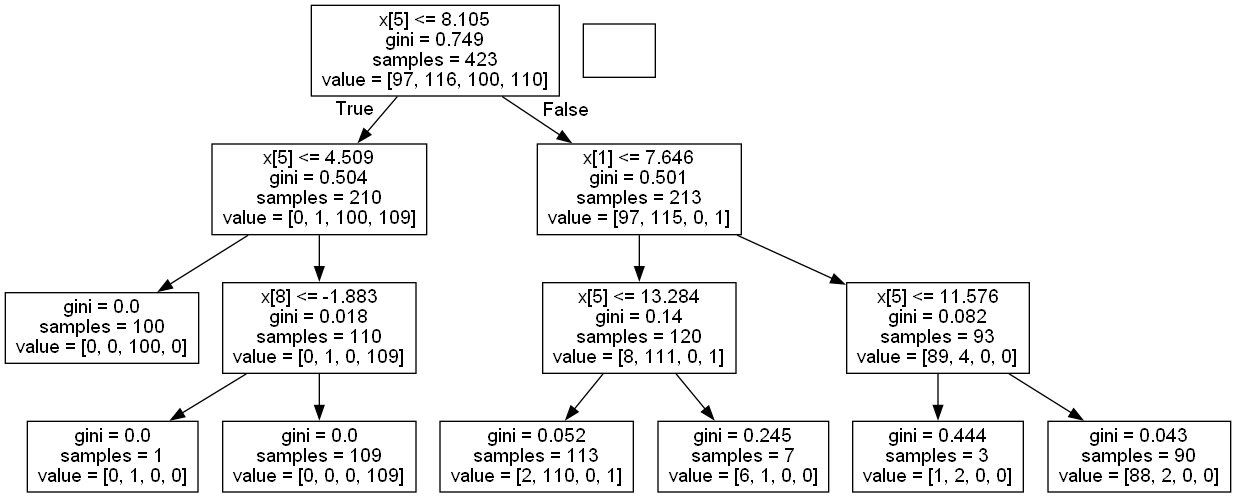

In [4]:
import pydotplus
dot_data = 'Tree.dot'
tree.export_graphviz(Model, out_file=dot_data) # モデル入力
graph = pydotplus.graphviz.graph_from_dot_file(dot_data)

# jupyterで表示
from IPython.display import Image
Image(graph.create_png())

次に特徴量を2つピックアップし、散布図を作成してみましょう。  
こちらはx軸、y軸の標準偏差を示しています。  
行動ラベルによってプロットが固まっていることがわかります

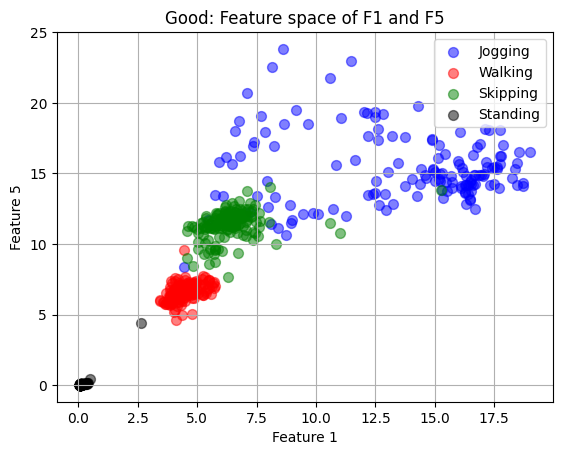

In [6]:
from matplotlib import pyplot as plt

# N, A1, A2の順に散布図を作成
ax1 = 1
ax2 = 5
plt.scatter(Data_1.iloc[:,ax1], Data_1.iloc[:,ax2], s=50, c='blue', alpha=0.5)
plt.scatter(Data_2.iloc[:,ax1], Data_2.iloc[:,ax2], s=50, c='red', alpha=0.5)
plt.scatter(Data_3.iloc[:,ax1], Data_3.iloc[:,ax2], s=50, c='green', alpha=0.5)
plt.scatter(Data_4.iloc[:,ax1], Data_4.iloc[:,ax2], s=50, c='black', alpha=0.5)

plt.title("Good: Feature space of F" + str(ax1) + " and F" + str(ax2))
plt.xlabel("Feature " + str(ax1))
plt.ylabel("Feature " + str(ax2))
plt.grid(True) #グリッド線（True:引く、False:引かない）

plt.legend(["Jogging", "Walking", "Skipping", "Standing"]) # 凡例

学習したモデルを用いて分類を行います。  
識別結果を混同行列で示します。  
混同行列は、実際のラベルと予測されたラベルの関係を示しています。  
対角成分が正しく認識されたことを示しています。  
詳しくは[こちら](https://evaluelog.com/post-107/)をご覧ください  
混同行列を見れば、
- どのようなラベルの認識が特に難しかったか、よくできていたか
- どのようなラベルがどのようなラベルと間違えられやすかったか  

このようなことがわかります。

In [7]:
Y_test_est = Model.predict(X_test)

from sklearn.metrics import confusion_matrix
print(confusion_matrix(Y_test, Y_test_est))

[[46  4  0  0]
 [ 0 43  0  0]
 [ 0  0 45  0]
 [ 0  0  0 44]]


そして、様々な評価値を確認しましょう。  
上から適合率(precision)、再現率(recall)、F値(F-measure)を示しています。  
また、リストは各ラベルごとにどれだけ評価値を得られたかを示しています。  
そして、最終行のリストは各ラベルのデータ量を示しています。 

In [8]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(Y_test, Y_test_est)

(array([1.        , 0.91489362, 1.        , 1.        ]),
 array([0.92, 1.  , 1.  , 1.  ]),
 array([0.95833333, 0.95555556, 1.        , 1.        ]),
 array([50, 43, 45, 44], dtype=int64))

## 行動の分類(交差検証法)

次に交差検証法を用いて行動の分類を行っていきます。  
分類を行うには、まず識別器に訓練用データを学習させ、評価用データを用いて認識精度を確認します。  
しかし、訓練用データと評価用データに同じデータがあった場合、未知のデータに対応できるとは考えられません。  
そのため、あらかじめ訓練用データと評価用データに同じものが入らないように分割する必要があります。  
そして、認識精度の偏りをなくすため、訓練用データと評価用データを変えながら、複数回(今回は5回)行うことで、すべてのデータを評価していきます。

<img src="Image/image_AR/交差検証.svg" width="500">


In [9]:
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
    
#KFoldの設定(5個に分割)
kf = KFold(n_splits = 5, shuffle = True, random_state = 1)

label = df_feature['activity_label']
label = label.values

data = df_feature.drop('activity_label', axis=1)
data = data.values

Model = tree.DecisionTreeClassifier(criterion='gini', min_samples_leaf=1 , max_depth=3) # モデル構造の定義

all_test = []
all_pred = []

#5回分割、学習、テストを行う
for train, test in kf.split(data):
    train_data , train_label = data[train] , label[train]
    test_data , test_label = data[test] , label[test]
    
    Model = Model.fit(train_data, train_label) # 学習開始
    
    y_pred = Model.predict(test_data)
    
    all_test.extend(test_label)
    all_pred.extend(y_pred)
    
confusion_matrix(all_test, all_pred), precision_recall_fscore_support(all_test, all_pred)

(array([[137,  10,   0,   0],
        [  9, 149,   0,   1],
        [  0,   0, 145,   0],
        [  0,   1,   0, 153]], dtype=int64),
 (array([0.93835616, 0.93125   , 1.        , 0.99350649]),
  array([0.93197279, 0.93710692, 1.        , 0.99350649]),
  array([0.93515358, 0.93416928, 1.        , 0.99350649]),
  array([147, 159, 145, 154], dtype=int64)))

全てのデータをテストしているため、データ量も増え、検証の有効性が高まったと考えられます。

## 付録

### 決定木の構築方法

本編では述べませんでしたが、ここでは決定木がどのように構築されていくかを説明します。
はじめに、全データをルートノードに与えた状態から考えます。ルートノードに与えられた全データの最もうまく分割する基準を探し、データを2分割します。分割後、それぞれのノードで同じ作業を繰り返し行い、それぞれのノードが1種類のデータを持つようになるまでこの作業を行います。

<img src="Image/image_math/classification_method.svg" width="600" alt="決定木構築">

この最もうまく分割する指標を**不純度**といい、複数の種類があるので代表的な**ジニ不純度**と**情報エントロピー**の2つについて以下で説明します。

### ジニ不純度

**ジニ不純度**は決定木において代表的に用いられる不純度の指標です。あるノード$t$において与えられているサンプルが全部で$n$個あり、クラスが$c$種類ある状態を考えます。このとき、クラス$i$に属するサンプルの個数を$n_i$とするとジニ不純度$I_G(t)$は以下の式で表されます。

$$I_G(t)=1-\sum_{i=1}^{c}(\frac{n_i}{n})^2 \quad$$

上記の式からジニ不純度はノード$t$に含まれる全てのサンプルが全て同じクラスに属する状態で計算すると$0$になり、全てサンプルがすべて異なる状態で計算すると$1-\frac{1}{n}$となります。  
**scikit-learn**という機械学習用のライブラリでデフォルトで設定されている不純度はジニ不純度です。

### 情報エントロピー

**情報エントロピー**は物事の乱雑さを図る物理の指標です。
あるノード$t$において与えられているサンプルが全部で$n$個あり、クラスが$c$種類ある状態を考えます。このとき、クラス$i$に属するサンプルの個数を$n_i$とすると情報エントロピー$I_H(t)$は以下の式で表されます。
$$I_H(t)=-\sum_{i=1}^{c}(\frac{n_i}{n})log_2 p(\frac{n_i}{n}) \quad$$

上記の式から情報エントロピーはノード$t$に含まれる全てのサンプルが全て同じクラスに属する状態で計算すると$0$になり、全てサンプルがすべて異なる状態で計算すると$log_2 n$となります。  

### 情報利得

ここまで2つの不純度について説明しました。決定木では分割の基準となる特徴量や閾値を求めるため、
$$(分割前の不純度)-(分割後の不純度)$$
が最大になるように、つまり分割後の不純度が最小になるように判定条件を計算していきます。この上記の式を**情報利得**といいます。  
ここで、不純度にはジニ不純度を用いる場合の情報利得を考えます。親ノード$D_p$を2つの子ノード$D_{left}, D_{right}$に分割するとし、親ノードに与えられたサンプル数を$N_p$、子ノードに与えられたサンプル数をそれぞれ$N_{left}, N_{right}$、分割する特徴量を$f$としたとき、情報利得$IG(D_p,f)$は以下の式で表されます。
$$IG(D_p,f)=I_G(D_p)-\frac{N_{left}}{N_p}I_G(D_{left})-\frac{N_{right}}{N_p}I_G(D_{right})$$
$I_G(D_p)$が分割前の不純度にあたり、$\frac{N_{left}}{N_p}I_G(D_{left})+\frac{N_{right}}{N_p}I_G(D_{right})$が分割後の不純度にあたります。  
この情報利得が最大になるように計算していくのが決定木というアルゴリズムです。  
今回説明したのは特徴量に対してYESかNOの条件によって二分木を構築する方法で**CART法**と呼ばれています。他に使われているアルゴリズムとしては、3つ以上の分岐が可能な**C4.5（C5.0）**があります。

## Pythonプログラミング以外の分類方法
本実験では、Pythonによるプログラミングにて特徴量抽出や行動に識別を行いましたが、別の方法もありますのでこちらに記載いたします。  
それは、Wekaという機械学習ソフトウェアを用いる方法で、AccARFFConvertというソフトウェアを用いて、特徴量をWekaに入力できる形で記載します。  
AccARFFConvertの詳しい使い方については、AccARFFConvert_manualを参照してください。  
また、Wekaの詳しい使い方については、Weka_manualを参照してください。
### AccARFFConvertによる特徴量抽出
作成したアノテーションデータとセンサデータをもとにWekaで使用する一つのデータファイルにまとめます。  
*AccARFFConvert*を用いてアノテーションデータとセンサデータからスライディングウインドウ形式で部分系列を抽出し、特徴量を計算します。  
そして、アノテーションラベルと特徴量を結び付けて、Wekaに入力するためのARFFを拡張子とするデータとします。  
このとき、計測した加速度データに対して「平均」「分散」「エネルギー」「エントロピー(周波数領域)」の4つの特徴量を計算しています。  
最終的に得られたデータファイルを確認してみましょう。  
抽出した特徴量データ、そしてアノテーションラベルが連結されて保存されていることが分かります。

<img src="Image/image_AR/特徴量データ.svg" width="500">

### Wekaによる分類

前節で作成したデータファイル(.arff)を用いて、加速度データを用いて人の動作のパターン識別を行いましょう。  
パターン識別を行うソフトとして、*Weka*を使用します。Wekaの使い方は、付属資料を参考にしてください。  
それぞれの被験者で計測したセンサデータに対して複数のパターン識別手法を実施してみましょう。  
ここでは、決定木を用いて解析した結果を表示しています。

<img src="Image/image_AR/決定木.svg" width="500">